In [1]:
import hdf5plugin
import h5py    
import numpy as np  
import pandas as pd

In [2]:
def print_all_datasets(group, prefix=''):
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            print(prefix + key)  # Print the dataset name
        elif isinstance(item, h5py.Group):
            print_all_datasets(item, prefix + key + '/')  # Recursively explore groups
            
def list_datasets(group, prefix=''):
    for key in group.keys():
        item = group[key]
        if isinstance(item, pd.DataFrame):
            print(prefix + key)  # Print the dataset path
        elif isinstance(item, pd.io.pytables.HDFStore):
            list_datasets(item, prefix + key + '/')  # Recursively explore groups


default_colors = {0: 'green', 1: 'blue', 2: 'orange', 3: 'red'}
import matplotlib.pyplot as plt
import matplotlib

In [3]:
region_name = 'LCT_regions'
celltype = 'enterocytes'
fold = 'fold_0'
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

regions_df = pd.read_csv('region_scores/'+celltype+'/'+region_name+"/"+fold+".interpreted_regions.bed", sep='\t', names=NARROWPEAK_SCHEMA)

seq_length = 2114
regions_df['int_start'] = regions_df['start']+regions_df['summit']-seq_length/2
regions_df['int_end'] = regions_df['start']+regions_df['summit']+seq_length/2



In [4]:
def get_model_score(file_path,sequence_number):
    import h5py
    # Open the HDF5 file
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        dataset = f['shap']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get contribution_scores
        df = pd.DataFrame(dataset[sequence_number][:])
    
        # Access the dataset
        dataset = f['raw']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get sequence
        df2 = pd.DataFrame(dataset[sequence_number][:])


        # Access the dataset
        dataset = f['projected_shap']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get sequence
        df4 = pd.DataFrame(dataset[sequence_number][:])

    df3 = df*df2

    return(df2,df3)
        

In [5]:
sequence_number = 0
sequence_chr,sequence_start,sequence_end = regions_df.loc[sequence_number,'chr'],int(regions_df.loc[sequence_number,'int_start']),int(regions_df.loc[sequence_number,'int_end'])
seq_list = []
folds = ['fold_0','fold_1','fold_2','fold_3','fold_4']
i = 0
for fold in folds:

    file_path = 'region_scores/'+celltype+'/'+region_name+"/"+fold+".profile_scores.h5"
    dataset_key = '/projected_shap/seq'  # Adjust the dataset key as needed

    seq,model_score_fold = get_model_score(file_path,sequence_number)
    seq_list.append(seq)
    if i == 0:
        model_score_sum = model_score_fold
        i+=1
    else:
        model_score_sum = model_score_sum + model_score_fold

model_score_avg = model_score_sum/len(folds)

In [6]:
seq_df = model_score_avg.T
seq_df.columns = ['A','C','G','T']

In [7]:
seq_df

,A,C,G,T
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
2109,0.0,0.0,0.0,0.0
2110,0.0,0.0,0.0,0.0
2111,0.0,0.0,0.0,0.0
2112,0.0,0.0,0.0,0.0


In [8]:

import numpy as np
# Generate a 100bp grid
grid = np.linspace(0, 2114, num=22)
# Round each grid value to the nearest multiple of 100
rounded_grid = np.round(grid / 100) * 100
# Add starting position
grid2 = [x+sequence_start for x in rounded_grid]
# Round to nearest multiple of 100
rounded_grid2 = np.round(np.array(grid2) / 100) * 100
rounded_grid2 = [int(x) for x in rounded_grid2]
#Reset locations
tick_locations = [x-sequence_start for x in rounded_grid2]
#Add chr to first tick
rounded_grid2 = [str(x) for x in rounded_grid2]
rounded_grid2[0] = sequence_chr+": " + str(rounded_grid2[0])

In [9]:
region_name

'LCT_regions'

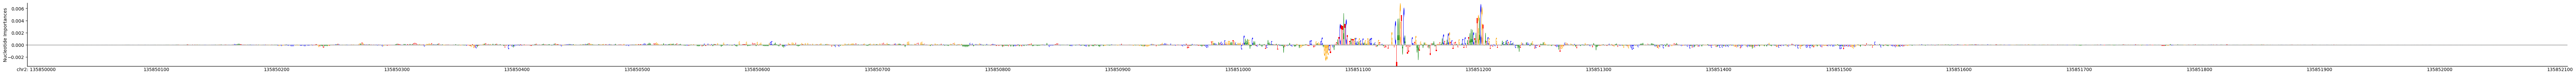

In [10]:
# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df,figsize=(100, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+".png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+".pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [11]:
max_contrib = np.abs(seq_df.T).max()
max_contrib_Z = (max_contrib-max_contrib.mean())/max_contrib.std()

In [12]:
max_contrib_Z_thresh = max_contrib_Z[max_contrib_Z>2]
min_pos = np.array(max_contrib_Z_thresh.index).min()
max_pos = np.array(max_contrib_Z_thresh.index).max()

min_pos = np.max([min_pos - 20,1])
max_pos = np.min([max_pos+20,2000])
seq_df_trimmed = seq_df.loc[min_pos:max_pos,:]
print(len(seq_df_trimmed.index))

244


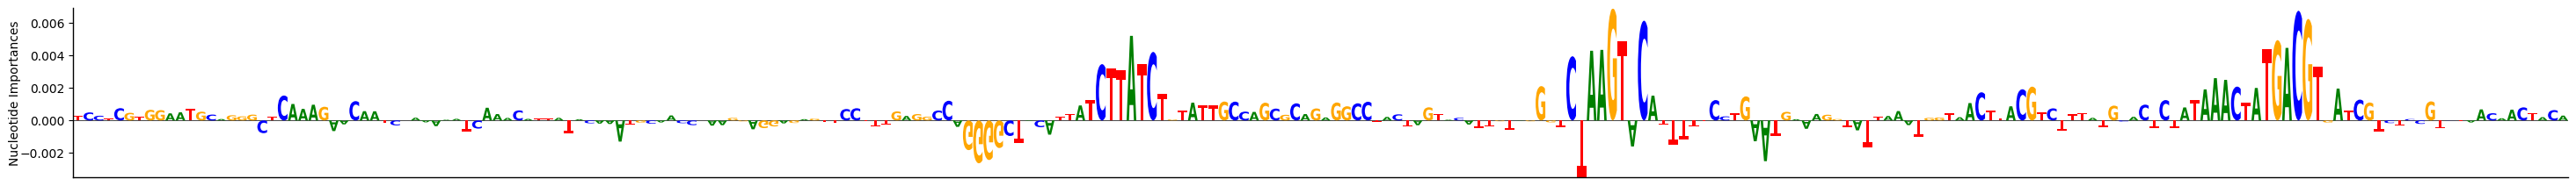

In [13]:
# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df_trimmed,figsize=(100/2000*len(seq_df_trimmed.index)*3, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
#plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_2.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_2.pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [14]:
max_contrib_Z_thresh = max_contrib_Z[max_contrib_Z>5]
min_pos = np.array(max_contrib_Z_thresh.index).min()
max_pos = np.array(max_contrib_Z_thresh.index).max()

min_pos = np.max([min_pos - 20,1])
max_pos = np.min([max_pos+20,2000])
seq_df_trimmed = seq_df.loc[min_pos:max_pos,:]
print(len(seq_df_trimmed.index))

160


In [15]:
ISM_df = pd.read_csv("LCT_ISM_study_effects_wcounts.tsv",sep="\t",index_col=0)

In [16]:
ISM_df_trimmed = ISM_df.loc[ISM_df['pos']<=max_pos]
ISM_df_trimmed = ISM_df_trimmed.loc[ISM_df_trimmed['pos']>=min_pos]


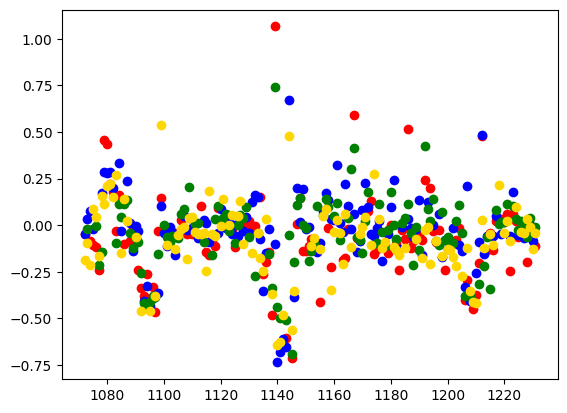

In [17]:
for base in ['A','C','G','T']:
    df_base = ISM_df_trimmed.loc[ISM_df_trimmed['alt']==base].copy()

    x,y = df_base['pos'],df_base['log_counts_diff_avg']

    if base=='A':
        plt.plot(x,y,'o',c='r')
    if base=='C':
        plt.plot(x,y,'o',c='b')
    if base=='G':
        plt.plot(x,y,'o',c='g')
    if base=='T':
        plt.plot(x,y,'o',c='gold')
plt.show()
plt.close()

In [18]:
min_pos,max_pos

(1072, 1231)

In [19]:
regions_df

,chr,start,end,1,2,3,4,5,6,summit,int_start,int_end
0,chr2,135850768,135851620,human_peaks_peak_46168,428,.,9.08804,45.6806,42.8412,282,135849993.0,135852107.0


In [20]:
135851067-regions_df['int_start']

0    1074.0
Name: int_start, dtype: float64

In [21]:
ISM_df['pos_loc'] = ISM_df['pos'] + int(regions_df['int_start'])

/scratch/tmp.1426519.jjanssens/ipykernel_2334666/4069582029.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ISM_df['pos_loc'] = ISM_df['pos'] + int(regions_df['int_start'])


In [23]:
seq_df_trimmed

,A,C,G,T
1072,0.000000,0.000000,0.000553,0.0
1073,0.000273,0.000000,0.000000,0.0
1074,-0.000000,0.000000,0.000391,0.0
1075,-0.000000,0.000000,0.000230,0.0
1076,0.000000,0.000609,0.000000,0.0
...,...,...,...,...
1227,0.000678,0.000000,0.000000,0.0
1228,0.000000,0.000443,0.000000,0.0
1229,0.000131,0.000000,0.000000,0.0
1230,0.000662,0.000000,0.000000,0.0


In [22]:
ISM_df['pos_loc']

0       135849993
1       135849993
2       135849993
3       135849994
4       135849994
          ...    
6337    135852105
6338    135852105
6339    135852106
6340    135852106
6341    135852106
Name: pos_loc, Length: 6342, dtype: int64

In [27]:
ISM_df.loc[ISM_df_trimmed.index,'pos_loc'].

3216    135851065
3217    135851065
3218    135851065
3219    135851066
3220    135851066
          ...    
3691    135851223
3692    135851223
3693    135851224
3694    135851224
3695    135851224
Name: pos_loc, Length: 480, dtype: int64

In [28]:
135851065-135851224

-159

In [26]:
ISM_df_trimmed

,pos,ref,alt,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--log_probs_diff_abs_sum,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg
3216,1072,G,A,4.442946,-0.132634,-46.088980,-0.022074,4.548340,0.010396,19.836260,...,-26.547686,-0.012143,4.084962,-0.038612,-21.776218,-0.013950,-0.047344,4.712777,-17.560059,-0.009878
3217,1072,G,C,4.533230,-0.042350,-22.550236,-0.012469,4.542701,0.004758,27.667055,...,-36.010376,-0.015412,4.033737,-0.089837,-40.244038,-0.019310,-0.045551,4.714570,-17.281778,-0.009136
3218,1072,G,T,4.369333,-0.206247,-73.989440,-0.033006,4.431828,-0.106115,-62.658577,...,-79.782130,-0.031833,3.902414,-0.221160,-84.830400,-0.037248,-0.187175,4.572946,-73.213610,-0.032069
3219,1073,A,C,4.661760,0.086180,25.225588,0.014934,4.708892,0.170949,48.675484,...,22.861328,0.017051,4.045227,-0.078348,-42.538902,-0.024240,0.032346,4.792467,4.425481,0.002380
3220,1073,A,G,4.631000,0.055419,19.836164,0.012250,4.616086,0.078143,26.076008,...,-25.577490,-0.013488,4.001841,-0.121733,-50.891090,-0.023861,-0.019005,4.741116,-10.928244,-0.005159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3691,1230,A,G,4.511252,-0.064328,-25.602077,-0.012391,4.495890,-0.042053,-22.051770,...,-20.504019,-0.010725,4.112219,-0.011355,-21.273762,-0.011693,-0.029449,4.730672,-21.606100,-0.011707
3692,1230,A,T,4.362656,-0.212924,-73.890700,-0.030775,4.386847,-0.151096,-54.084305,...,-58.353065,-0.023655,4.079067,-0.044508,-38.496136,-0.017948,-0.128046,4.632075,-55.170920,-0.023114
3693,1231,C,A,4.449440,-0.126140,-56.917580,-0.024708,4.393370,-0.144574,-67.628494,...,-48.466003,-0.022138,4.046631,-0.076943,-46.303070,-0.022606,-0.113117,4.647004,-52.597810,-0.024968
3694,1231,C,G,4.558353,-0.017227,-18.281977,-0.011547,4.531057,-0.006886,-17.923370,...,-13.293083,-0.008399,4.080058,-0.043516,-21.331520,-0.010628,-0.010096,4.750026,-9.358513,-0.005902


In [ ]:
135851067

135851076

In [ ]:
135851076

In [39]:
ISM_df.loc[ISM_df['pos_loc']==135851076]

,pos,ref,alt,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg,pos_loc
3249,1083,C,A,4.436561,-0.139019,-33.550590,-0.016344,4.557500,0.019557,21.784058,...,0.014153,4.179593,0.056018,29.809902,0.017020,-0.029413,4.730708,4.090327,0.002866,135851076
3250,1083,C,G,4.334312,-0.241268,-50.798683,-0.022104,4.531725,-0.006218,-25.503765,...,-0.016582,4.092129,-0.031445,-21.722980,-0.014688,-0.095525,4.664596,-31.528482,-0.017324,135851076
3251,1083,C,T,4.742331,0.166751,56.336723,0.025332,4.830871,0.292928,86.505570,...,0.019658,4.487145,0.363571,110.284966,0.044938,0.266632,5.026752,77.083120,0.032768,135851076


In [36]:
regions_df

,chr,start,end,1,2,3,4,5,6,summit,int_start,int_end
0,chr2,135850768,135851620,human_peaks_peak_46168,428,.,9.08804,45.6806,42.8412,282,135849993.0,135852107.0


In [40]:
highlight_SNP = {}
highlight_SNP[1083] = 'T'

In [41]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logomaker
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib

def plot_region_ISM(seq_df, ISM_df, highlight_SNP=None, save_path=None):
    base_colors = {
        'A': 'g',
        'C': 'b',
        'G': 'gold',
        'T': 'r'
    }

    len_seq = len(seq_df)
    min_pos = np.min(seq_df.index)
    max_pos = np.max(seq_df.index)

    # Create a figure
    fig = plt.figure(figsize=(300 / 2000 * len_seq, 5))

    # Create a GridSpec with 2 rows and 1 column
    gs = gridspec.GridSpec(2, 1, figure=fig)

    # Create axes in each grid cell with shared x-axis
    axes = [fig.add_subplot(gs[i, 0]) for i in range(2)]

    # Plot the sequence logo
    ax = axes[0]
    crp_logo = logomaker.Logo(seq_df, shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)

    ax.set_ylabel("Nucleotide Importances", fontsize=10)

    # Plot the ISM data
    ax1 = axes[1]
    ax1.axhline(y=0, color='black', linewidth=1, linestyle='--')

    ax1.set_ylabel("$\Delta$ Log[counts]", fontsize=10)
    
    for base in ['A', 'G', 'T', 'C']:
        df_base = ISM_df[ISM_df['alt'] == base].copy()
        x, y = df_base['pos'], df_base['log_counts_diff_avg']
        ax1.scatter(x, y, c=base_colors[base], label=base)

    if highlight_SNP:
        for pos, base in highlight_SNP.items():
            df_base = ISM_df[(ISM_df['alt'] == base) & (ISM_df['pos'] == pos)]
            x, y = df_base['pos'], df_base['log_counts_diff_avg']
            ax1.scatter(x, y, c=base_colors[base], edgecolors='k', linewidths=2)

    ax1.set_xlim([min_pos, max_pos])

    # Adding legend to the second subplot
    ax1.legend()

    if save_path:
        plt.savefig(save_path,dpi=350,bbox_inches='tight',pad_inches=0)
    plt.show()
    plt.close()


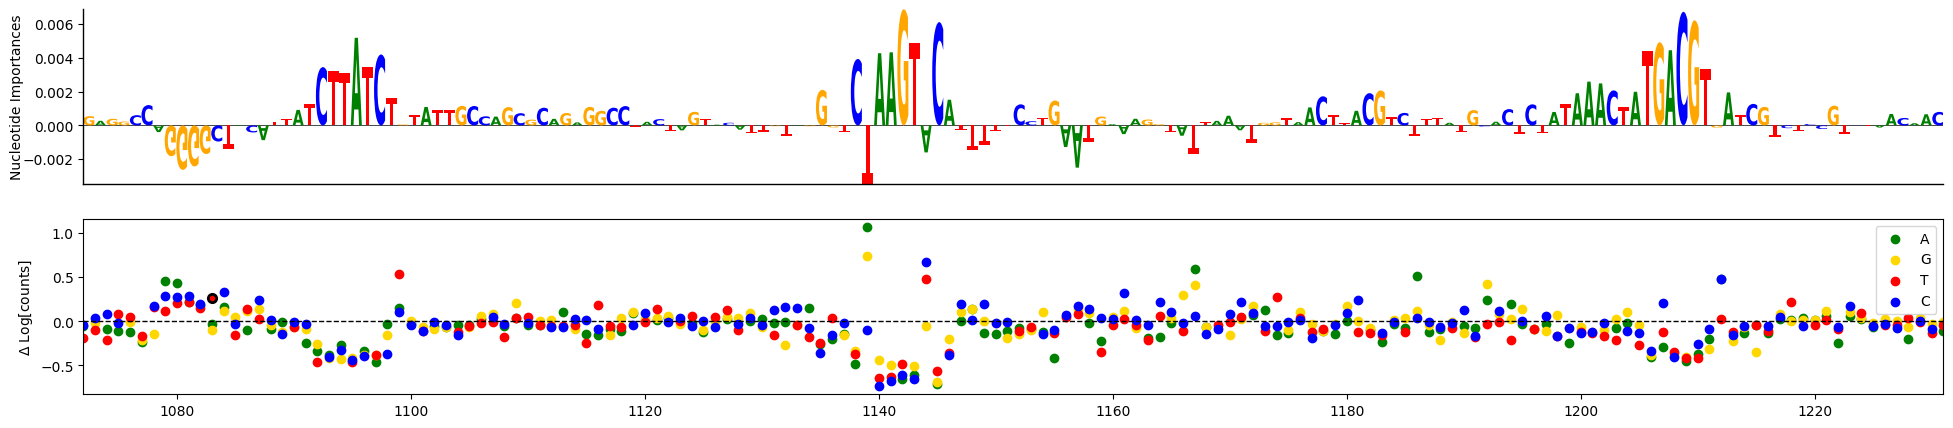

In [42]:
plot_region_ISM(seq_df_trimmed, ISM_df_trimmed,highlight_SNP=highlight_SNP,save_path="region_plots/enterocytes_LCT_regions_0_trimmed_5_withISM.pdf")

In [ ]:
135851065-135851224

In [46]:
135849993+1220

135851213

In [132]:
min_pos

976

In [ ]:
135851076

In [134]:
143118405+1060

143119465

In [ ]:
135851076

In [44]:
regions_df['int_start']

0    135849993.0
Name: int_start, dtype: float64

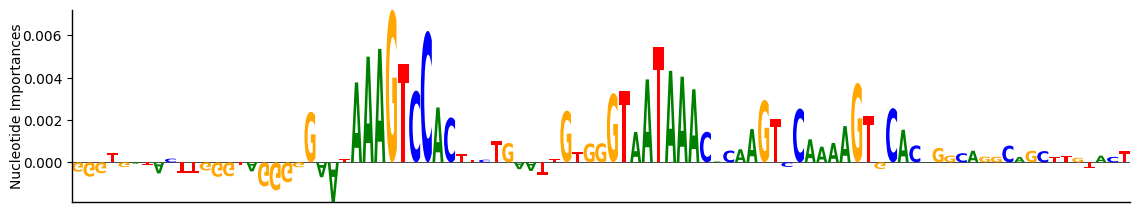

In [13]:
# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df_trimmed,figsize=(100/2000*len(seq_df_trimmed.index)*3, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
#plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_5.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_5.pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [14]:
seq_df

,A,C,G,T
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
2109,0.0,0.0,0.0,0.0
2110,0.0,0.0,0.0,0.0
2111,0.0,0.0,0.0,0.0
2112,0.0,0.0,0.0,0.0


In [ ]:
# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df_trimmed,figsize=(100/2000*len(seq_df_trimmed.index)*3, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
#plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_5.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_5.pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [36]:
# Define the data
LCT_MPRA = {
    'chrom': ['chr2', 'chr2', 'chr2', 'chr2', 'chr2', 'chr2'],
    'pos': [135850865, 135850896, 135851127, 135851170, 135851196, 135851249],
    'ref': ['T', 'C', 'A', 'A', 'A', 'C'],
    'alt': ['C', 'A', 'G', 'G', 'C', 'T']
}

# Create the DataFrame
LCT_MPRA = pd.DataFrame(LCT_MPRA)


In [37]:
LCT_MPRA['pos_loc'] = LCT_MPRA['pos'] - 1

In [54]:
LCT_MPRA_effects = []
for snc in LCT_MPRA.index:
    snc_pos = LCT_MPRA.loc[snc,'pos_loc']
    snc_ref = LCT_MPRA.loc[snc,'ref']
    snc_alt = LCT_MPRA.loc[snc,'alt']

    ISM_df_locus = ISM_df.loc[ISM_df['pos_loc']==snc_pos].copy()
    if list(ISM_df_locus['ref'])[0]==snc_ref:
        print('position and ref match')
        log_counts_diff_avg = ISM_df_locus.loc[ISM_df_locus['alt']==snc_alt,'log_counts_diff_avg'].values[0]
        logcount_preds_avg = ISM_df_locus.loc[ISM_df_locus['alt']==snc_alt,'logcount_preds_avg'].values[0]
        probs_jsd_diff_avg = ISM_df_locus.loc[ISM_df_locus['alt']==snc_alt,'probs_jsd_diff_avg'].values[0]
        log_probs_diff_abs_sum_avg = ISM_df_locus.loc[ISM_df_locus['alt']==snc_alt,'log_probs_diff_abs_sum_avg'].values[0]
        LCT_MPRA_effects.append(dict(snc_pos=snc_pos,ref=snc_ref,alt=snc_alt,
                                    log_counts_diff_avg=log_counts_diff_avg,
                                    logcount_preds_avg=logcount_preds_avg,
                                    probs_jsd_diff_avg=probs_jsd_diff_avg,
                                    log_probs_diff_abs_sum_avg=log_probs_diff_abs_sum_avg))
LCT_MPRA_effects = pd.DataFrame(LCT_MPRA_effects)

position and ref match
position and ref match
position and ref match
position and ref match
position and ref match
position and ref match


In [56]:
LCT_MPRA_effects.to_csv("region_ISM/enterocytes/LCT_region_MPRA.tsv",sep="\t")

In [57]:
LCT_MPRA_effects

,snc_pos,ref,alt,log_counts_diff_avg,logcount_preds_avg,probs_jsd_diff_avg,log_probs_diff_abs_sum_avg
0,135850864,T,C,-0.000702,4.759419,0.003638,5.111495
1,135850895,C,A,-0.011564,4.748557,-0.009414,-13.892705
2,135851126,A,G,-0.044420,4.715701,-0.002885,-6.475092
3,135851169,A,G,0.111174,4.871295,0.023229,53.549385
4,135851195,A,C,-0.016452,4.743670,-0.003584,-10.440020
5,135851248,C,T,-0.035544,4.724577,-0.010171,-17.886435


In [53]:
ISM_df_locus.loc[ISM_df_locus['alt']==snc_alt,'log_counts_diff_avg'].values

array([-0.03554449])

In [41]:
snc_pos

135851248

In [39]:
ISM_df.loc[ISM_df['pos_loc']==135850864]

,pos,ref,alt,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg,pos_loc
2613,871,T,A,4.581477,0.005897,10.380392,0.006185,4.545789,0.007845,10.571497,...,0.006747,4.123031,-0.000543,-11.615817,-0.008270,0.002392,4.762514,1.152522,0.000808,135850864
2614,871,T,C,4.580987,0.005407,12.003126,0.006594,4.540329,0.002385,11.277872,...,0.005781,4.128757,0.005183,10.298159,0.007595,-0.000702,4.759419,5.111495,0.003638,135850864
2615,871,T,G,4.575959,0.000379,15.740711,0.008438,4.536626,-0.001318,-11.673296,...,-0.006204,4.107308,-0.016266,-13.242813,-0.009563,-0.003236,4.756885,-1.015897,-0.001150,135850864


In [33]:
ISM_df.loc[ISM_df['pos_loc']==135850895]

,pos,ref,alt,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg,pos_loc
2706,902,C,A,4.568191,-0.007389,-11.736637,-0.008277,4.525456,-0.012487,-11.791552,...,-0.008715,4.117899,-0.005675,-13.709799,-0.010919,-0.011564,4.748557,-13.892705,-0.009414,135850895
2707,902,C,G,4.571009,-0.004571,-13.753626,-0.008637,4.512795,-0.025148,-11.350245,...,-0.008661,4.123595,0.000021,12.807812,0.008666,-0.010659,4.749462,-7.778606,-0.005416,135850895
2708,902,C,T,4.548049,-0.027532,-14.975218,-0.008065,4.509152,-0.028791,-14.827906,...,-0.007564,4.106638,-0.016936,-14.000580,-0.009802,-0.022754,4.737367,-15.711876,-0.008766,135850895


In [32]:
ISM_df.loc[ISM_df['pos_loc']==135850864]

,pos,ref,alt,fold_0--logcount_preds,fold_0--log_counts_diff,fold_0--log_probs_diff_abs_sum,fold_0--probs_jsd_diff,fold_1--logcount_preds,fold_1--log_counts_diff,fold_1--log_probs_diff_abs_sum,...,fold_3--probs_jsd_diff,fold_4--logcount_preds,fold_4--log_counts_diff,fold_4--log_probs_diff_abs_sum,fold_4--probs_jsd_diff,log_counts_diff_avg,logcount_preds_avg,log_probs_diff_abs_sum_avg,probs_jsd_diff_avg,pos_loc
2613,871,T,A,4.581477,0.005897,10.380392,0.006185,4.545789,0.007845,10.571497,...,0.006747,4.123031,-0.000543,-11.615817,-0.008270,0.002392,4.762514,1.152522,0.000808,135850864
2614,871,T,C,4.580987,0.005407,12.003126,0.006594,4.540329,0.002385,11.277872,...,0.005781,4.128757,0.005183,10.298159,0.007595,-0.000702,4.759419,5.111495,0.003638,135850864
2615,871,T,G,4.575959,0.000379,15.740711,0.008438,4.536626,-0.001318,-11.673296,...,-0.006204,4.107308,-0.016266,-13.242813,-0.009563,-0.003236,4.756885,-1.015897,-0.001150,135850864


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logomaker
import numpy as np

# Assuming len_seq and celltypes are defined
len_seq = 2000
celltypes = ['enterocytes','EEC','Goblet_cell','Stem_cell']

# Create a figure
fig = plt.figure(figsize=(300/2000*len_seq, 2.5*len(celltypes)))

# Create a GridSpec with 1 column and rows equal to the number of cell types
gs = gridspec.GridSpec(len(celltypes), 1, figure=fig)

# Create axes in each grid cell with shared y-axis
axes = [fig.add_subplot(gs[i, 0]) for i in range(len(celltypes))]

# Plot each cell type
for ax, celltype in zip(axes, celltypes):
    ax.set_title(celltype)
    model_score_avg = model_scores_celltypes[celltype].copy()
    seq_df = model_score_avg.T
    seq_df.columns = ['A','C','G','T']
    
    # Create Logo object
    crp_logo = logomaker.Logo(seq_df, figsize=(300/2000*len_seq, 2.5), shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)
    ax.set_xticks(ticks=tick_locations)
    ax.set_xticklabels(rounded_grid2)

# Set shared y-axis limits (workaround, sharey does not work with logomaker)
y_min, y_max = np.min([ax.get_ylim()[0] for ax in axes]), np.max([ax.get_ylim()[1] for ax in axes])
for ax in axes:
    ax.set_ylim(y_min, y_max)

# Display the plot
plt.tight_layout()
plt.savefig("region_plots/multi_celltypes/"+region_name+"_"+str(sequence_number)+".pdf",bbox_inches='tight',pad_inches=0)
plt.show()
